Dans cette partie, nous allons afficher les éoliennes sur la carte de France

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("eolien.csv", sep=";")

In [5]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaN,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


On retrouve ici l'emplacement de l'éolienne, ainsi que la longueur des pales, ce qui sont les informations qui nous intéressent dans un premier temps. 

On convertit la colonnes date_maj en date interprétable plus facilement

In [6]:
import datetime

df.date_mise_en_service = pd.to_datetime((df.date_mise_en_service))

In [7]:
df.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,type_feu_desc,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,NaN,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,NaN,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaN,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN


In [8]:
df.count()

id_aerogenerateur        7483
id_parc                  7483
code_insee               7483
nom_commune              7483
code_dept                7483
code_reg                 7483
puissance                7483
hauteur_totale           7483
hauteur_mat_nacelle      7483
diametre_rotor           7483
cote_ngf                 7483
periode_allumage_lib     7483
periode_allumage_desc       0
type_feu_lib             7483
type_feu_desc               0
date_mise_en_service     4331
constructeur             7483
reference_modele         7483
x_aerogenerateur         7483
y_aerogenerateur         7483
epsg                     7483
libelle                  7483
date_maj                 7483
nom_eolienne              347
dtype: int64

Il y a 7483 éoliennes dans ce tableau. 
L'autre donnée intéressante est que nous n'avons que 4331 date de mise en service soit 58% de date de mise en service. 

On convertit cela pour avoir des données exploitables par geopandas

In [24]:
!pip install pandas fiona shapely pyproj rtree  #Sur colab, sinon bug
# à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

ERROR: Invalid requirement: '#'


  Using cached contextily-1.2.0-py3-none-any.whl (16 kB)
  Using cached geopy-2.3.0-py3-none-any.whl (119 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
  Using cached rasterio-1.2.10.tar.gz (2.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\peign\anaconda3\python.exe' 'C:\Users\peign\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\peign\AppData\Local\Temp\tmpd_0r92wk'
       cwd: C:\Users\peign\AppData\Local\Temp\pip-install-i1bdgsdi\rasterio
  Complete output (2 lines):
  INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
  ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
  ----------------------------------------
ERROR: Command errored out with exit status 1: 'C:\Users\peign\anaconda3\python.exe' 'C:\Users\peign\anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\peign\AppData\Local\Temp\tmpd_0r92wk' Check the logs for full command output.


In [17]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
!pip install --upgrade botocore==1.23.26  #Sur colab, sinon bug

ModuleNotFoundError: No module named 'contextily'

In [14]:
from shapely.geometry import Point
geometrie = [Point(xy) for xy in zip(df.x_aerogenerateur,df.y_aerogenerateur)] # colonnes du DataFrame résultants
caract_eoliennes = gpd.GeoDataFrame(df,geometry=geometrie)
caract_eoliennes = caract_eoliennes.set_crs(2154, allow_override=True)

In [15]:
caract_eoliennes.head()

,id_aerogenerateur,id_parc,code_insee,nom_commune,code_dept,code_reg,puissance,hauteur_totale,hauteur_mat_nacelle,diametre_rotor,...,date_mise_en_service,constructeur,reference_modele,x_aerogenerateur,y_aerogenerateur,epsg,libelle,date_maj,nom_eolienne,geometry
0,0005503449_E1,5503449,35068,CHATEAUBOURG,35,53,1.0,99.7,73.0,53.0,...,2011-04-23,ENERCON,E-53,371155.00,6786614.0,2154,Lambert-93,2022-05-19,NaN,POINT (371155.000 6786614.000)
1,0005306849_E1,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395860.28,6887806.5,2154,Lambert-93,2022-05-31,NaN,POINT (395860.280 6887806.500)
2,0005306849_E2,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395830.44,6886987.0,2154,Lambert-93,2022-05-31,NaN,POINT (395830.440 6886987.000)
3,0005306849_E3,5306849,50363,MOYON VILLAGES,50,28,2.3,124.0,83.0,82.0,...,2014-04-01,ENERCON,E-82 E2,395760.56,6886064.0,2154,Lambert-93,2022-05-31,NaN,POINT (395760.560 6886064.000)
4,0003102050_E1,3102050,16317,ST FRAIGNE,16,75,3.6,180.0,119.0,126.0,...,NaT,VESTAS,V126-3.6MW,463180.00,6547301.0,2154,Lambert-93,2022-06-22,NaN,POINT (463180.000 6547301.000)


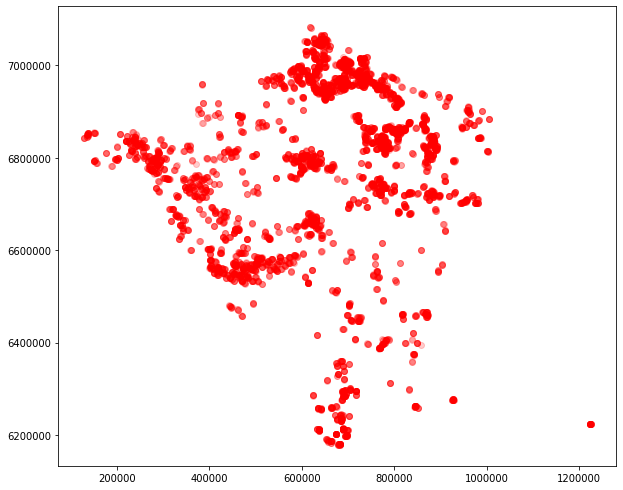

In [19]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

On va désormais afficher une carte de France pour afficher les éoliennes sur la carte 

On utilise le paquet Cartiflette 

In [21]:
!pip install --upgrade urllib3==1.22.0 #Sur colab, sinon bug
!pip install py7zr #Sur colab, sinon bug
!pip install s3fs #Sur colab, sinon bug
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

ERROR: Invalid requirement: '#Sur'
ERROR: Invalid requirement: '#Sur'
ERROR: Invalid requirement: '#Sur'


C:\Users\peign\cartogether


fatal: destination path 'cartogether' already exists and is not an empty directory.


Processing c:\users\peign\cartogether
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'


ERROR: Package 'cartiflette-0.0.1' requires a different Python: 3.7.6 not in '>=3.8'


In [25]:
from cartiflette.download import get_vectorfile_ign

In [26]:
france = get_vectorfile_ign(
    field="metropole",
    level="REGION",
    year=2022)

https://wxs.ign.fr/x02uy2aiwjo9bm8ce5plwqmr/telechargement/prepackage/ADMINEXPRESS_SHP_WGS84G_PACK_2022-06-21$ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21/file/ADMIN-EXPRESS_3-1__SHP__FRA_WM_2022-06-21.7z


Downloading: : 563MiB [03:11, 3.07MiB/s] 


In [27]:
france = france[0:13] #On retire les outre-mers de la carte
france.head()

,ID,NOM_M,NOM,INSEE_REG,geometry
0,REGION_FXX_0000000000001,ILE-DE-FRANCE,Île-de-France,11,"POLYGON ((2.85612 49.07009, 2.85616 49.07011, ..."
1,REGION_FXX_0000000000002,CENTRE-VAL DE LOIRE,Centre-Val de Loire,24,"POLYGON ((1.70924 48.57802, 1.70934 48.57801, ..."
2,REGION_FXX_0000000000003,BOURGOGNE-FRANCHE-COMTE,Bourgogne-Franche-Comté,27,"POLYGON ((5.40561 47.64813, 5.40490 47.64851, ..."
3,REGION_FXX_0000000000004,NORMANDIE,Normandie,28,"MULTIPOLYGON (((-1.51486 48.66017, -1.51483 48..."
4,REGION_FXX_0000000000005,HAUTS-DE-FRANCE,Hauts-de-France,32,"POLYGON ((2.80921 49.09753, 2.80762 49.09682, ..."


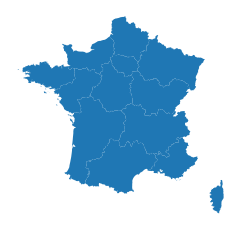

In [28]:
ax = france.plot()
ax.set_axis_off()

Désormais, nous allons rajouter les éoliennes sur notre carte de France

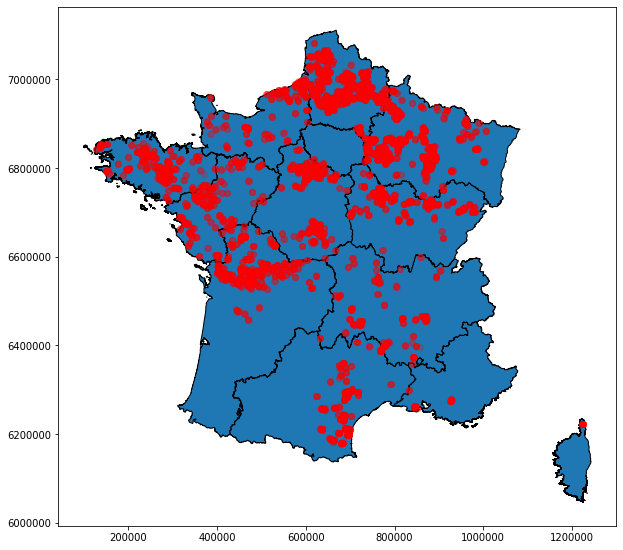

In [29]:
fig,ax = plt.subplots(figsize=(10, 10))
caract_eoliennes.plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")

On rajoute de l'interactivité

In [30]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


Voici toutes les éoliennes pour lesquelles nous ne possédons pas les dates d'installations (3152 éoliennes soit 42% des éoliennes que nous avons affiché jusqu'ici) :

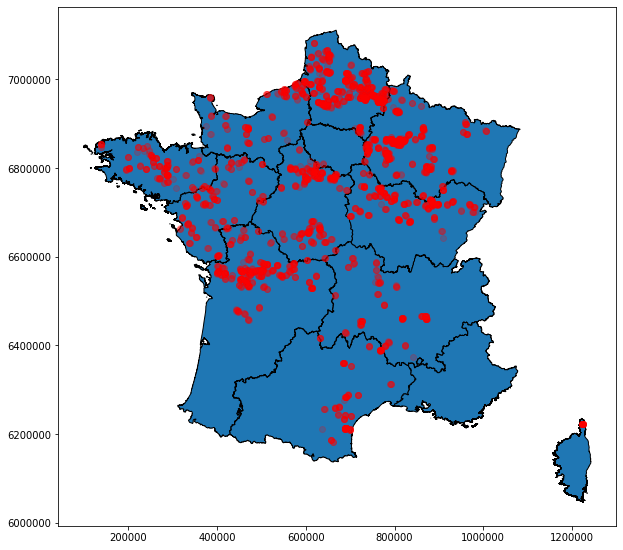

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)

Pour celles dont nous connaissons la date, nous affichons ici l'évolution du parc d'éolienne en fonction du temps

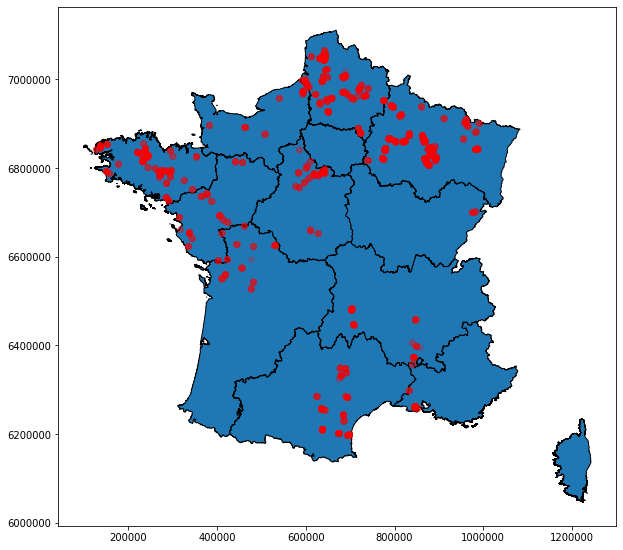

<function __main__.signal_plot(annee)>

In [33]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))


from ipywidgets import interact

def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)   
    
interact(signal_plot,
            annee=periode)

En affichant celle dont on ne connait pas date d'installation en vert on n'obtient ce graphique :

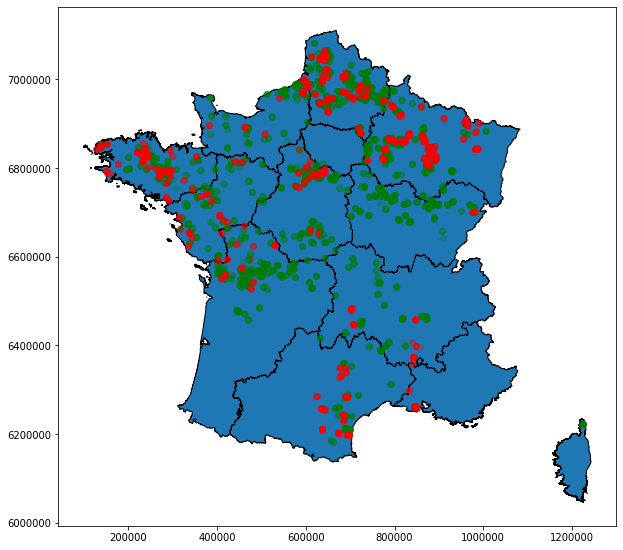

<function __main__.signal_plot(annee)>

In [34]:
periode = pd.Series(pd.date_range("2010", freq="Y", periods=14))



from ipywidgets import interact


def signal_plot(annee):
    fig, ax = plt.subplots(figsize=(10,10))
    france.to_crs(2154).plot(ax = ax, zorder=1, edgecolor = "black")
    # Plot les éoliennes
    caract_eoliennes[caract_eoliennes.date_mise_en_service.isna()].plot(ax = ax, color = 'green', alpha = 0.2, zorder=2)  
    caract_eoliennes[caract_eoliennes.date_mise_en_service < annee].plot(ax = ax, color = 'red', alpha = 0.2, zorder=2)  

interact(signal_plot,
            annee=periode)

Tentative de récupération des données de ventTentative de récupération des données météo via OpenWeatherMap

In [35]:
import json
import requests

Exemple d'utilisation de l'api pour récupérer les données de vent à une latitude/longitude donnée à une date donnée

In [36]:
base_url = "https://archive-api.open-meteo.com/v1/era5?"
latitude=str(52.52)
longitude=str(13.41)
start_date="2022-06-08"
end_date="2012-12-04"
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date

reponse = requests.get(complete_url)
#print(reponse.content)

On va essayer de récupérer le vent pour une éolienne, par exemple la prémière de notre ligne 

In [37]:
caract_eoliennes = caract_eoliennes.to_crs(4326)

In [38]:
a = caract_eoliennes.geometry[0]
print(a)
print(a.x)

POINT (-1.4197135477946288 48.09705051237692)
-1.4197135477946288


In [39]:
latitude=str(a.y)
longitude=str(a.x)
start_date=str(pd.to_datetime(caract_eoliennes.date_mise_en_service[0]).date())
print(start_date)
end_date="2022-12-04"

2011-04-23


In [40]:
complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date


import json
json.rep = requests.get(complete_url).json()

In [41]:
donnees_vent = pd.DataFrame(json.rep['hourly'])

donnees_vent['time'] = pd.to_datetime(donnees_vent['time'])
donnees_vent = donnees_vent.set_index('time')

donnees_vent.head()

,windspeed_10m
time,
2011-04-23 00:00:00,2.34
2011-04-23 01:00:00,2.33
2011-04-23 02:00:00,1.80
2011-04-23 03:00:00,1.84
2011-04-23 04:00:00,1.70


On trace le graph du vent en fonction du temps pour cette éolienne

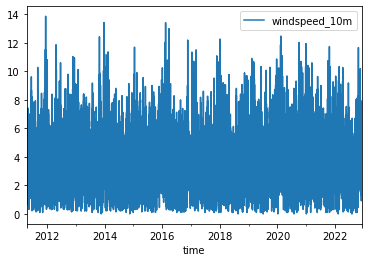

In [42]:
donnees_vent.plot()

Ici, on affiche les moyennes de vent par an et par mois

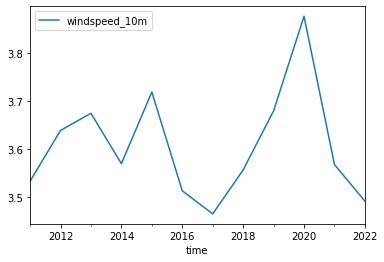

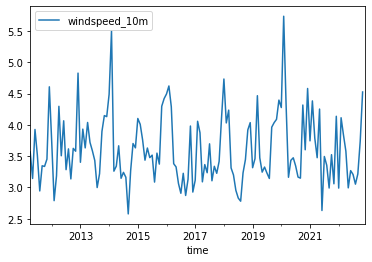

In [43]:
donnees_vent.resample('Y').mean().plot()
donnees_vent.resample('M').mean().plot()


La puissance d'une éolienne est donnée par $P = 1/2 \rho S V^3$ où $V$ est la vitesse du vent et $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 
Nous avons accès dans nos données à la longueur des pâles des éoliennes donc nous pouvons retrouver la puissance de l'éolienne.
L'énergie fournie sur une heure est donc cette puissance multiplié par le temps. Pour une éolienne, on peut considérer un facteur de charge de 16/27 (limite de Betz). Nous allons le prendre en compte pour calculer l'énergie fourni par une éolienne. 
Nous pourrions aller plus loin en prenant en compte la température et la pression qui influent sur la masse volumique de l'air $\rho$ et peuvent conduire à une variation de l'ordre de 20%.
Un truc intéressant à regarder serait la moyenne du vent par mois.

In [47]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * longueur_pale**2 * np.power(vitesse_vent,3)

In [51]:
diametre_rotor = caract_eoliennes['diametre_rotor'][0]
longueur_pale = caract_eoliennes['hauteur_totale'][0] - caract_eoliennes['hauteur_mat_nacelle'][0] # Je crois (Julien)

In [52]:
donnees_vent['energie'] = calcul_energie(diametre_rotor,donnees_vent['windspeed_10m'])

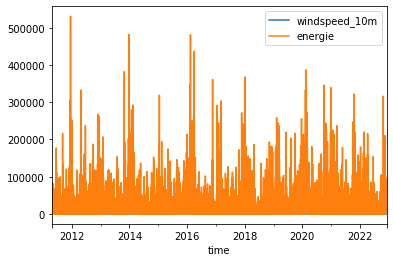

In [53]:
donnees_vent.plot()

Moyenne d'énergie sur le mois 

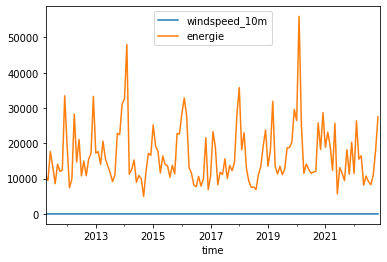

In [54]:
donnees_vent.resample('M').mean().plot()

Désormais, nous allons réaliser ces étapes pour chacune de nos éoliennes

In [55]:
caract_eoliennes = caract_eoliennes.to_crs(4326)

base_url = "https://archive-api.open-meteo.com/v1/era5?"

end_date="2022-12-04"

donnees_vent = []

for eolienne in caract_eoliennes.itertuples():
    a = eolienne.geometry
    longitude=str(a.x)
    latitude=str(a.y)
    date = pd.to_datetime(eolienne.date_mise_en_service).date()
    if pd.isnull(date):
        start_date = "2021-11-04" #On prend arbitrairement 1 an de météo
    else:
        start_date=str(date)
    complete_url = base_url + "latitude=" + latitude + "&longitude=" + longitude + "&hourly=windspeed_10m&windspeed_unit=ms&start_date="+start_date+"&end_date="+end_date
    reponse = requests.get(complete_url)
    donnees_vent_eolienne = pd.DataFrame(reponse.json())['hourly']
    if eolienne.Index%50 == 0 : 
        print(eolienne.Index)
    donnees_vent_eolienne['time'] = pd.to_datetime(donnees_vent_eolienne['time'])
    donnees_vent.append((eolienne.Index, donnees_vent_eolienne))


0
50
100
150
200
250


From cffi callback <function _verify_callback at 0x000002613BB0DF78>:
Traceback (most recent call last):
  File "C:\Users\peign\anaconda3\lib\site-packages\OpenSSL\SSL.py", line 311, in wrapper
    @wraps(callback)
KeyboardInterrupt


SSLError: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Max retries exceeded with url: /v1/era5?latitude=45.1175911471525&longitude=3.2743341187931096&hourly=windspeed_10m&windspeed_unit=ms&start_date=2011-04-06&end_date=2022-12-04 (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))

In [ ]:
caract_eoliennes.head()